In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Libraries
import os
import logging
import json
import glob
import pathlib
import datetime
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from functools import partial
from zoobot.tensorflow.estimators import define_model, efficientnet_standard, efficientnet_custom, custom_layers

In [3]:
# Some settings
# keras.mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel('ERROR')
%matplotlib inline

In [4]:
# Constants and initial parameters
IMAGE_SIZE = 300
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32    # 128 for paper, you'll need a very good GPU. 8 for debugging, 64 for RTX 2070, 256 for A100
CROP_SIZE = int(IMAGE_SIZE * 0.75)
RESIZE_SIZE = 224   # Zoobot, as pretrained, expects 224x224 images
CHANNELS = 1 # 1: grayscale, 3: RGB

MODEL_NAME = 'zoobot_for_clumps.keras'

TFRECORDS_PATH = '../Data/tf_records/'
TRAINING_FILENAMES = sorted(str(p) for p in pathlib.Path(TFRECORDS_PATH).glob('GZ2_ClumpScout_train*.tfrecords'))
VALID_FILENAMES = sorted(str(p) for p in pathlib.Path(TFRECORDS_PATH).glob('GZ2_ClumpScout_val*.tfrecords'))
TEST_FILENAMES = sorted(str(p) for p in pathlib.Path(TFRECORDS_PATH).glob('GZ2_ClumpScout_test*.tfrecords'))

In [5]:
def decode_image(image):
    image = tf.image.decode_png(image, channels=CHANNELS) # 1: output to greyscale
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE, CHANNELS])
    # image = tf.image.rgb_to_grayscale(image)
    image = (image / 255.0)
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            #'image/source_id': tf.io.FixedLenFeature([], tf.int64),
            'image/label': tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            #'image/source_id': tf.io.FixedLenFeature([], tf.int64),
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image/encoded'])
    #image_id = tf.cast(example['image/source_id'], tf.int64)
    if labeled:
        label = tf.cast(example['image/label'], tf.int32)
        return image, label #, image_id
    return image #, image_id
    
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_dataset(TEST_FILENAMES, labeled=True)

In [7]:
# load Zoobot, trainable
checkpoint_dir = '../Zoobot_checkpoints'
checkpoint_loc = os.path.join(checkpoint_dir, 'checkpoint')

conv_base = define_model.load_model(
    checkpoint_loc,  # loading pretrained model as above
    expect_partial=True,  # ignores some optimizer warnings
    include_top=False,  # do not include the head used for GZ DECaLS, this time - we will add our own head
    input_size=IMAGE_SIZE,  # the preprocessing above did not change size
    crop_size=CROP_SIZE,  # model augmentation layers apply a crop...
    resize_size=RESIZE_SIZE,  # ...and then apply a resize
    output_dim=None  # headless so no effect
)

conv_base.trainable = False

# Fine-tuning the pre-loaded model
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = conv_base(inputs)
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2, name="top_dropout")(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

# opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 7, 7, 1280)        4048989   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984 

In [ ]:
# full model - 150 epochs - save checkpoints
checkpoint_path = './checkpoints/cp-{epoch:04d}-{val_accuracy:.2f}.ckpt'
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
# use on commandline: tensorboard --logdir logs/fit

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1,
        save_weights_only=True,
        save_freq='epoch',
        monitor='val_accuracy',
    ),
    keras.callbacks.TensorBoard(
        log_dir=log_dir, 
        histogram_freq=1
    )
]

history = model.fit(
    train_dataset,
    epochs=90,
    validation_data=valid_dataset,
    callbacks=callbacks)

In [ ]:
with open('./trainHistoryDict.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

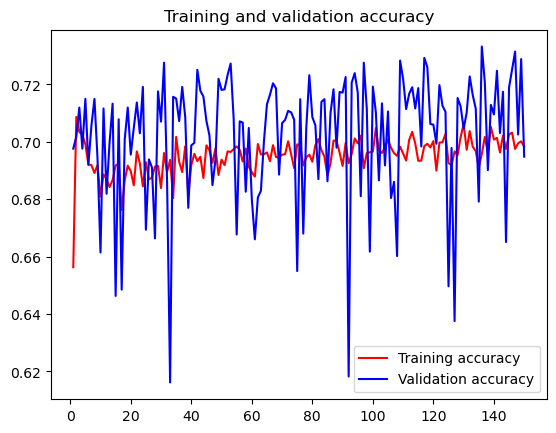

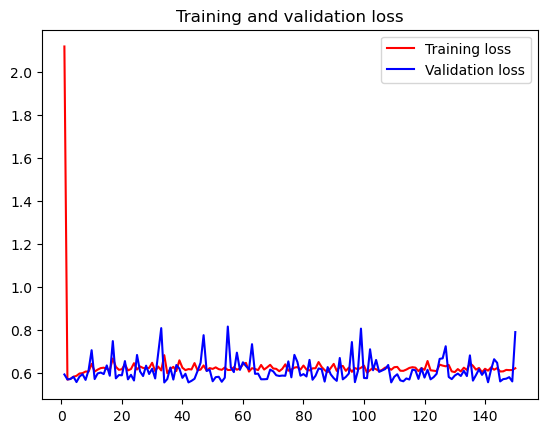

In [26]:
# Plotting results
acc = history["accuracy"]
val_acc = history["val_accuracy"]
loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [8]:
# Loads the weights
model.load_weights('./checkpoints/cp-0135.ckpt')

In [9]:
num_train = sum(1 for _ in train_dataset.unbatch())
num_valid = sum(1 for _ in valid_dataset.unbatch())
num_test = sum(1 for _ in test_dataset.unbatch())
print('Train: {}\nValidation: {}\nTest: {}'.format(num_train, num_valid, num_test))

2022-12-18 14:16:16.452842: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Train: 31950
Validation: 9128
Test: 4565


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

2022-12-17 17:31:18.291862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 17:31:18.456843: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_2/sequential_4/perma_random_crop_2/loop_body/cond/pfor/cond/branch_executed/_439


1/1 [==============================] - 0s 116ms/step


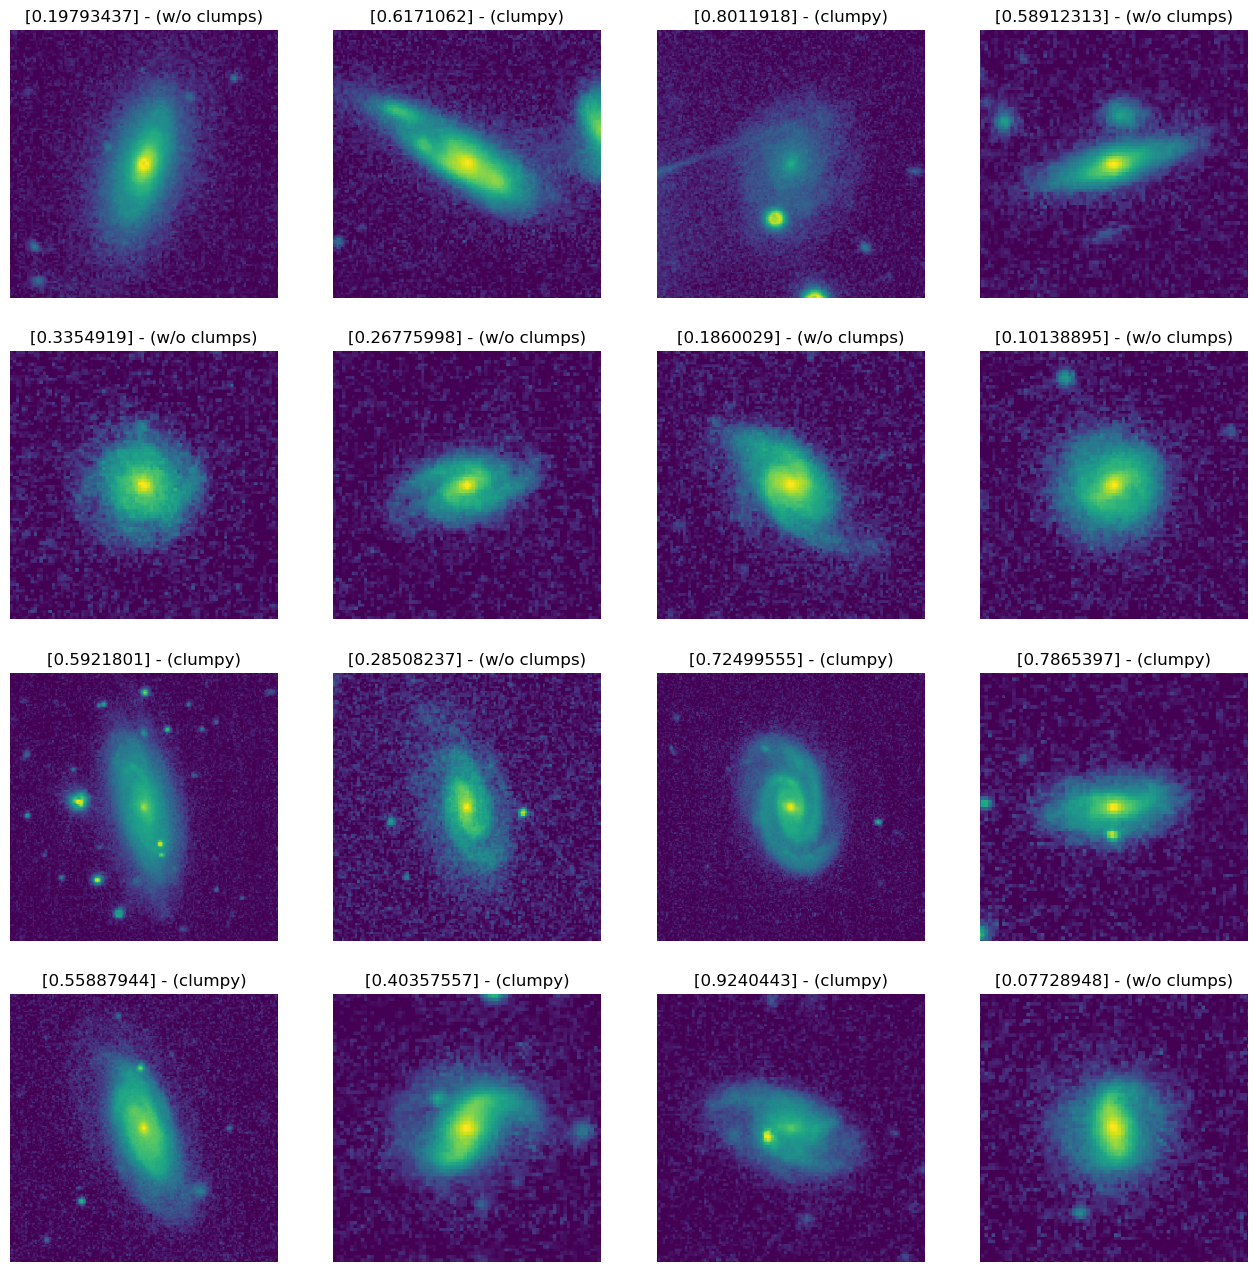

In [12]:
def show_batch_predictions(image_batch, label_batch):
    plt.figure(figsize=(16, 16))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        img_array = tf.expand_dims(image_batch[n], axis=0)
        pred = str(model.predict(img_array)[0])
        if label_batch[n]:
            plt.title(pred + ' - (clumpy)')
        else:
            plt.title(pred + ' - (w/o clumps)')
        plt.axis("off")

image_batch, label_batch = next(iter(test_dataset))
show_batch_predictions(image_batch.numpy(), label_batch.numpy())